# Game of 24

In [1]:
# Setup
import re
import os
import json
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

#############################################
# Just some util and plot styling functions #
#############################################
def get_files_in_folder(folder_path):
    files = []
    for file in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file)):
            files.append(folder_path + "/" +file)
    return files

def get_number(string):
    numbers = re.findall(r'\d+', string)
    numbers = list(map(int, numbers))
    return numbers[0] 
    
def get_params(file_path):
    data = {}

    file_name = file_path.split('/')[-1]
    params = file_name.split('_')

    data["set"] = params[0].split("-")[0]
    data["n_agents"] = get_number(params[1])
    data["n_steps"] = get_number(params[2])
    data["k"] = get_number(params[3])
    data["origin_value"] = get_number(params[4])
    data["backtrack"] = float("0." + str(get_number(params[5].split(".")[1])))
    data["resampling"] = params[6].split("-")[0]

    with open(file_path, 'r') as file:
        results = json.load(file)

    data["cost"] = results.pop("Cost")
    success = 0
    for experiment in results.values():
        if {"r":1} in experiment["Verifications"]:
            success +=1
    success_rate  = success/len(results)

    data["success_rate"] = success_rate
    data["file_path"] = file_path
    data["name"] = f"{data['n_agents']}agents\n{data['n_steps']}steps\n{data['k']}k\n{data['backtrack']}b"

    return data

def plot_sucess_rates(df_temp, ax1, ax2, tot_accuracy, tot_cost, sorted_on="NA"):
    # Plot the success rate on the first axes
    df_temp.plot(x="name", y="success_rate", kind="bar", title=f"Success Rate (sorted on {sorted_on})", ax=ax1, alpha=0.2)
    ax1.axhline(y=tot_accuracy, linestyle='--')  # Adding a horizontal line
    ax1.set_ylabel('success rate')
    ax1.grid(True)
    ax1.set_xticklabels([])  # Hide x-axis tick labels

    #Plot the cost on the second axes
    df_temp.plot(x="name", y="total_cost", kind="bar", title=f"Cost (sorted on {sorted_on})", ax=ax2, color="red", alpha=0.2)
    ax2.axhline(y=tot_cost, linestyle='--', color="red")  # Adding a horizontal line
    ax2.set_xlabel('parameters')
    ax2.set_ylabel('cost ($)')

    labels  = df_temp["name"].tolist()
    labels = [label if i%2==0 else "\n\n\n\n"+label for i, label in enumerate(labels)]
    ax2.set_xticklabels(labels, rotation=0) 
    ax2.grid(True)

def plot_per_agents_and_steps(df, tot_accuracy, tot_cost, k, save_to, figsize=(18, 12)):
    n_steps = sorted(df["n_steps"].unique(), reverse=True)
    n_agents = sorted(df["n_agents"].unique(), reverse=True)
    ks = sorted(df["k"].unique(), reverse=False)
    backtracking = df["backtrack"].unique()
    max_accuracy = df["success_rate"].max()
    max_cost = df["total_cost"].max()
    width = 0.4

    df.sort_values(by=["backtrack"], inplace=True)

    fig, axes = plt.subplots(len(n_steps), len(n_agents), figsize=figsize)

    for i, steps in enumerate(n_steps):
            for j, agents in enumerate(n_agents):
                cost_axis = axes[i,j].twinx()
                df[(df.n_steps==steps) & (df.n_agents==agents)].plot(x="backtrack", y="success_rate", ax=axes[i,j], title=f"{steps} steps, {agents} agents", kind="bar", alpha=0.2, width=-width, position=-width/2, label="FoA success_rate")
                df[(df.n_steps==steps) & (df.n_agents==agents)].plot(x="backtrack", y="total_cost", ax=cost_axis, title=f"{steps} steps, {agents} agents", kind="bar", color="red", alpha=0.2, width=width, position=width/2, label="FoA total_cost")
                axes[i,j].set_ylim(0, max_accuracy*1.1)
                axes[i,j].set_xlim(-0.65, len(backtracking)-0.5)
                cost_axis.set_ylim(0, max_cost*1.1)

                # Adding ToT benchmarks
                axes[i,j].axhline(y=tot_accuracy, color='b', linestyle='--', alpha=0.2, label="ToT success_rate")  # Adding a horizontal line
                cost_axis.axhline(y=tot_cost, color='r', linestyle='--', alpha=0.2, label="ToT total_cost")  # Adding a horizontal line

                # Remove legends
                axes[i,j].legend().remove()
                cost_axis.legend().remove()
                
                if i!=len(n_steps)-1:
                    axes[i,j].set_xticklabels([])
                    axes[i,j].set_xlabel("")
                
                if j==0:
                    axes[i,j].set_ylabel("Success Rate")
                
                if j==len(n_agents)-1:
                    cost_axis.set_ylabel("Cost ($)")

    # Combining legends
    lines, labels = axes[i,j].get_legend_handles_labels()
    lines2, labels2 = cost_axis.get_legend_handles_labels()
    plt.figlegend(lines + lines2, labels + labels2)

    plt.suptitle(f"Success Rate and Cost for different backtrack values (k={k})")

    plt.tight_layout()
    plt.savefig(save_to)
    plt.show()

In [2]:
# Accuracy and Cost from ToT benchmarks
tot_runs = get_files_in_folder("benchmarks/gameof24")
tot_accuracies = []
tot_costs = []

for run_file in tot_runs:
    with open(run_file, 'r') as file:
        run = json.load(file)

    # Compute cost
    cost = run[-1]["usage_so_far"]["cost"]
    tot_costs.append(cost)

    # Compute accuracy
    success = 0
    for puzzle in run:
        if {"r":1} in puzzle["infos"]:
            success +=1
    accuracy = success/len(run)
    tot_accuracies.append(accuracy)

tot_cost = sum(tot_costs)/len(tot_costs)
tot_accuracy = sum(tot_accuracies)/len(tot_accuracies)

print(f"Costs :      {[round(cost,2) for cost in tot_costs]}\t->\tMean: {tot_cost:.3f}")
print(f"Accuracies : {[round(accuracy,2) for accuracy in tot_accuracies]}\t->\tMean: {tot_accuracy:.3f}")

Costs :      [1.76, 1.6, 1.77, 1.73, 1.7]	->	Mean: 1.711
Accuracies : [0.25, 0.0, 0.23, 0.2, 0.0]	->	Mean: 0.136


# Initiail Gridsearch

In [3]:
files = get_files_in_folder("logs_recent/test/gameof24")

results = [get_params(file) for file in files]
results = sorted(results, key=lambda x: x["success_rate"], reverse=True)

df = pd.DataFrame(results)
df["input_tokens"] = df["cost"].apply(lambda x: x["input_tokens"])
df["output_tokens"] = df["cost"].apply(lambda x: x["output_tokens"])
df["total_cost"] = df["cost"].apply(lambda x: x["total_cost"])
df["name"] = df.apply(lambda x: f"{x['n_agents']}agents\n{x['n_steps']}steps\n{x['k']}k\n{x['backtrack']}b", axis=1)

## Success and cost

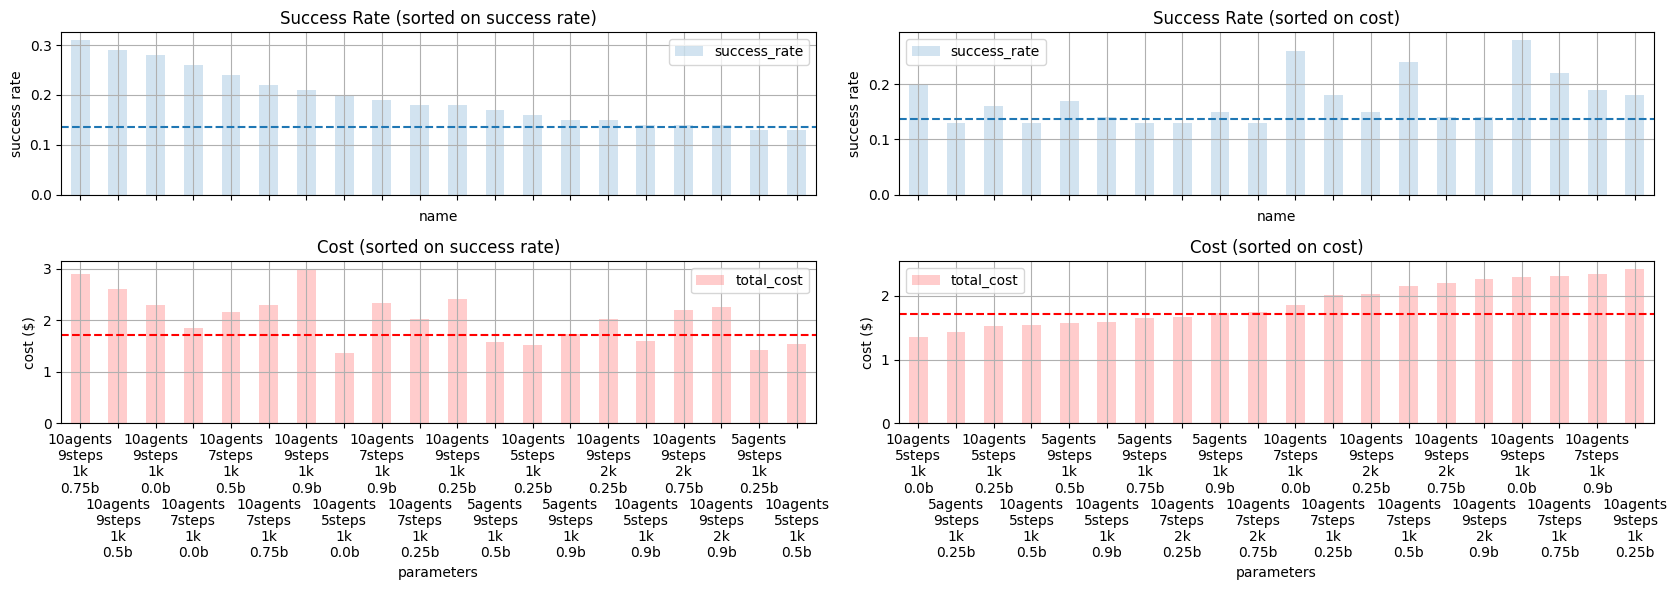

In [4]:
# prioritizing cost

import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axes = plt.subplots(2, 2, figsize=(17, 6))

# Plot sorted with success rate
df_temp = df.copy()
df_temp.sort_values(by=["success_rate", "total_cost"], ascending=[False, True], inplace=True)
df_temp = df_temp.head(20)
plot_sucess_rates(df_temp, axes[0,0], axes[1,0], tot_accuracy, tot_cost, sorted_on="success rate")

# Plot sorted with cost
df_temp = df.copy()
df_temp = df_temp[df_temp.success_rate > 0.12]
df_temp.sort_values(by=["total_cost", "success_rate"], ascending=[True, False], inplace=True)
df_temp = df_temp.head(20)
plot_sucess_rates(df_temp, axes[0,1], axes[1,1], tot_accuracy, tot_cost, sorted_on="cost")

# Adjust layout
plt.tight_layout()
plt.savefig("pics/gameof24/initial_gridsearch/best_sr_cost.png", dpi=300)
plt.show()

## Confidence intervals

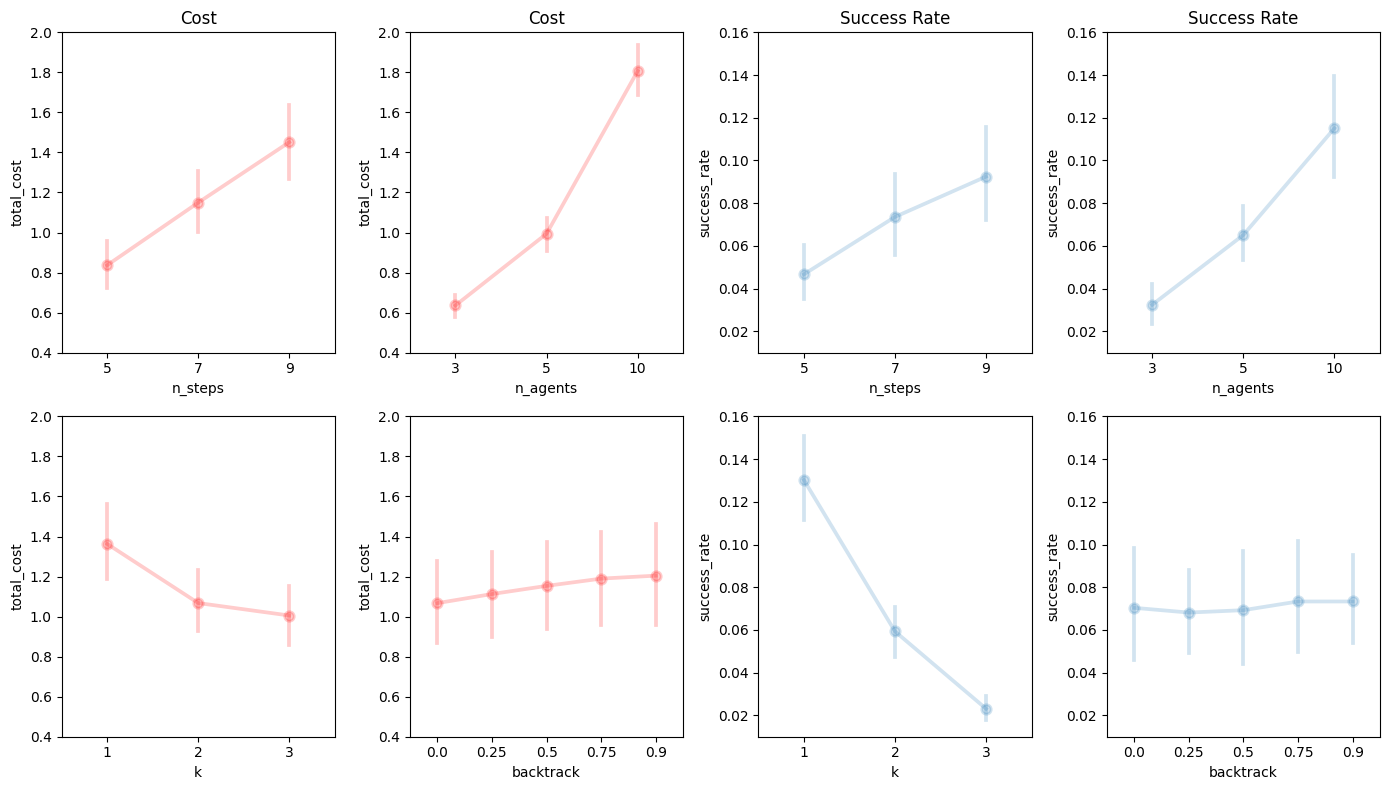

In [5]:
import seaborn as sns

fig, axes = plt.subplots(2, 4, figsize=(14, 8))
sns.pointplot(x="n_steps", y="total_cost", ax=axes[0,0], data=df, color="red", alpha=0.2)
sns.pointplot(x="n_agents", y="total_cost", ax=axes[0,1], data=df, color="red", alpha=0.2)
sns.pointplot(x="k", y="total_cost", ax=axes[1,0], data=df, color="red", alpha=0.2)
sns.pointplot(x="backtrack", y="total_cost", ax=axes[1,1], data=df, color="red", alpha=0.2)

sns.pointplot(x="n_steps", y="success_rate", ax=axes[0,2], data=df, alpha=0.2)
sns.pointplot(x="n_agents", y="success_rate", ax=axes[0,3], data=df, alpha=0.2)
sns.pointplot(x="k", y="success_rate", ax=axes[1,2], data=df, alpha=0.2)
sns.pointplot(x="backtrack", y="success_rate", ax=axes[1,3], data=df, alpha=0.2)

for i in range(2):
    for j in range(2):
        axes[i,j].set_ylim(0.4, 2)

for i in range(2):
    axes[0,i].set_title("Cost")

for i in range(2):
    for j in range(2,4):
        axes[i,j].set_ylim(0.01, 0.16)

for i in range(2):
    axes[0,i+2].set_title("Success Rate")

plt.tight_layout()
plt.savefig("pics/gameof24/initial_gridsearch/cis_per_param.png")
plt.show()

## Aggregated results for k

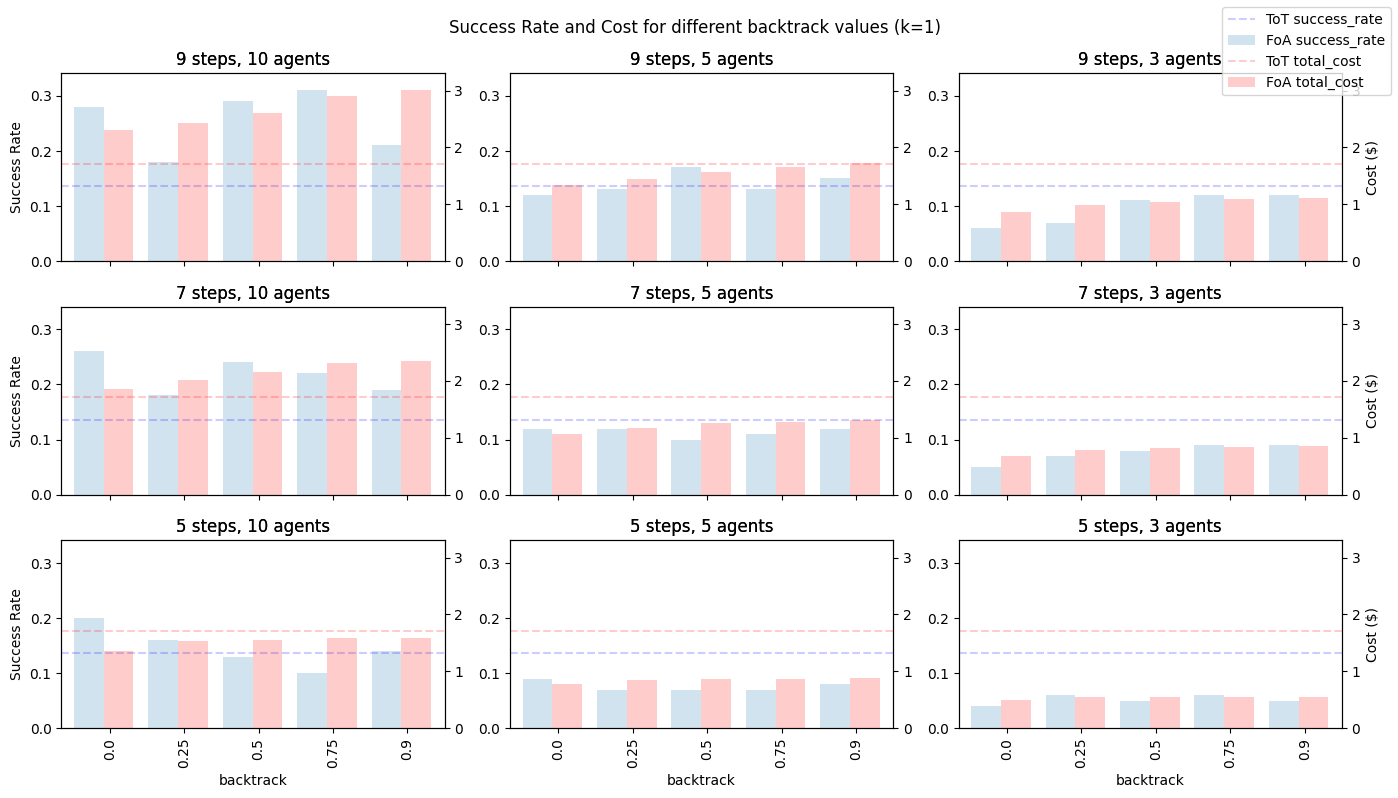

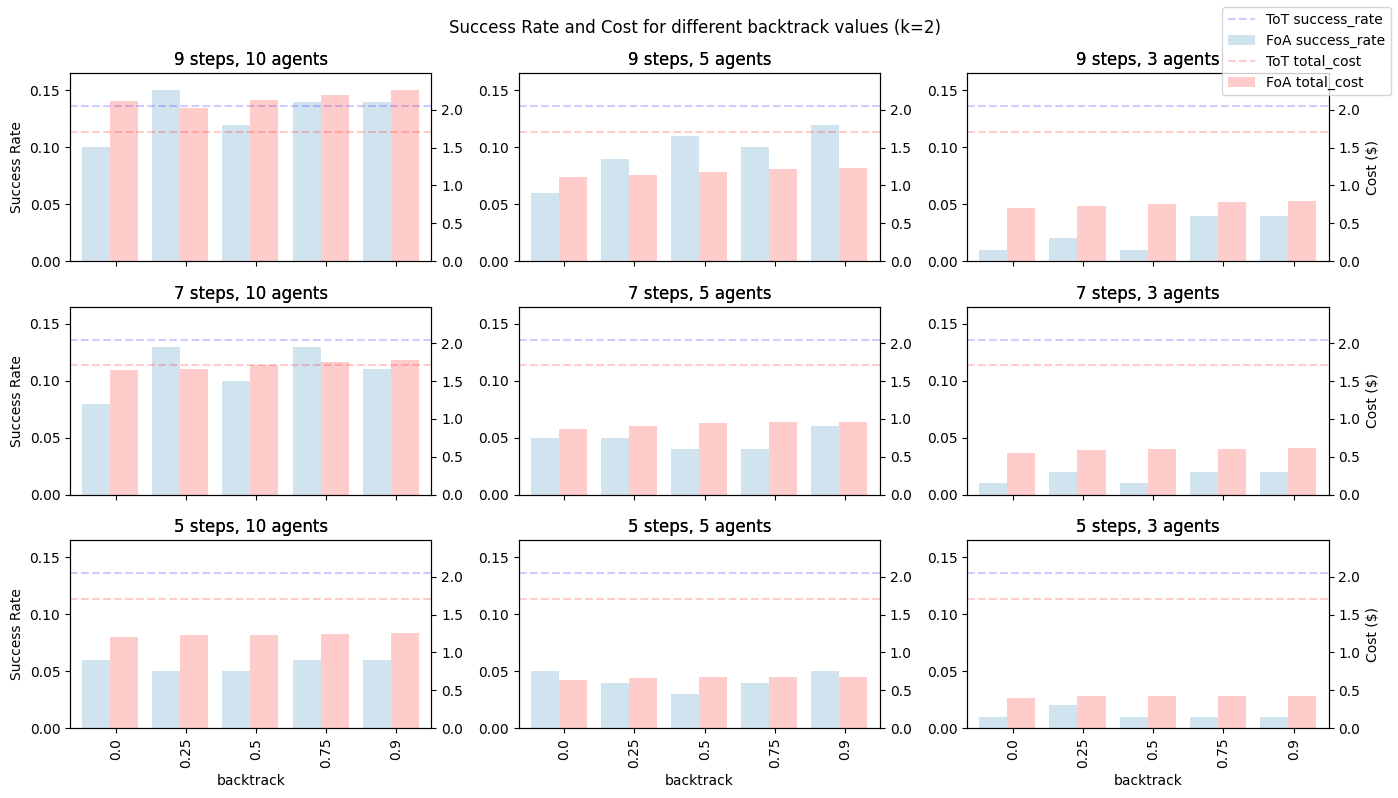

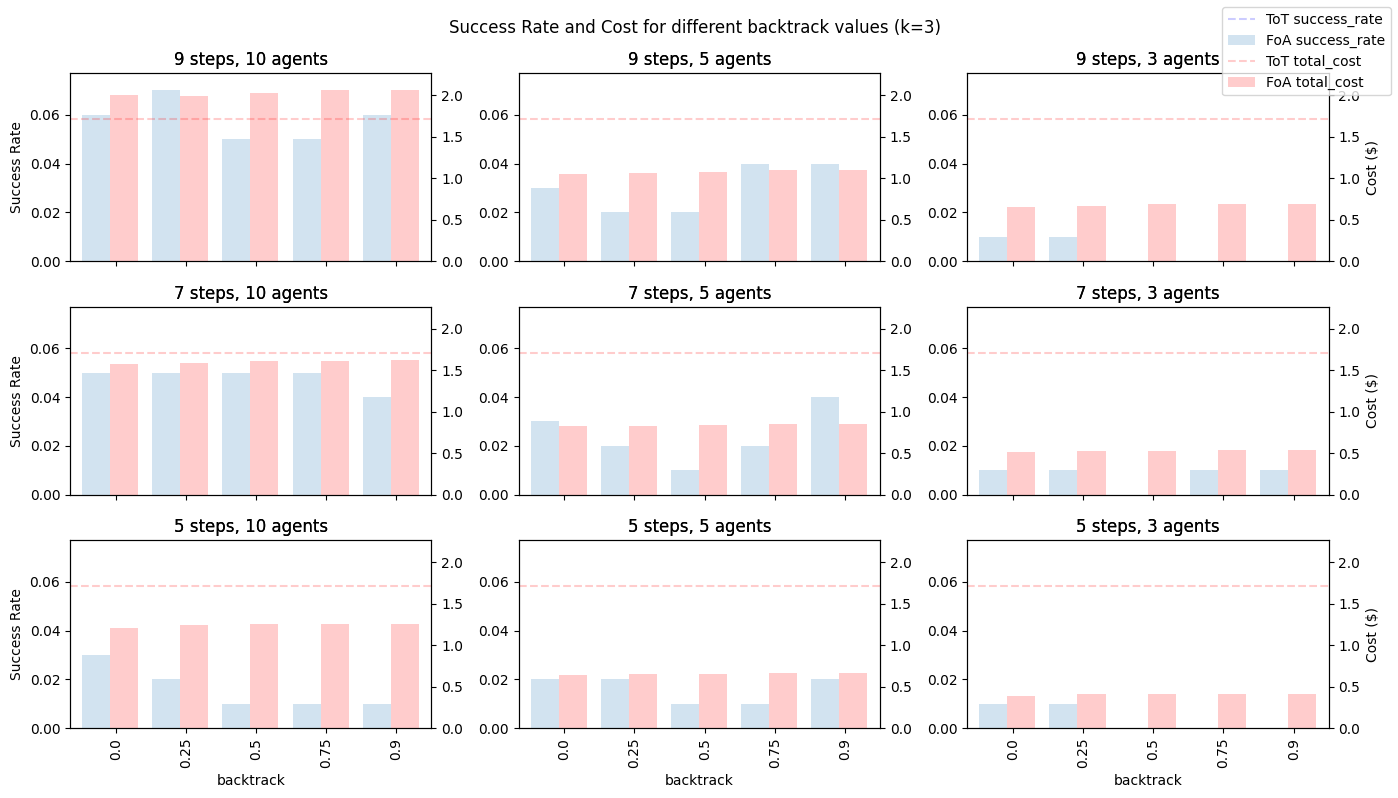

In [6]:
n_steps = df["n_steps"].unique()
n_agents = df["n_agents"].unique()
width = 0.4

for k in range(1,4):
    temp = df[df.k==k].copy()
    temp.sort_values(by=["backtrack"], inplace=True)
    plot_per_agents_and_steps(temp, tot_accuracy, tot_cost, k, save_to=f"pics/gameof24/initial_gridsearch/gridsearch_{k}k.png", figsize=(14, 8))

**Akhil's Comments:**

So basically, k=2 and k=3 are always bad. Thus, I don’t think we should be doing it!

For k=1, 3 agents is not an option. Also, 5 agents with 5 steps and 7 steps are also not an option.

Lucrative settings:
- 5 agents, 9 steps, backtrack = 0.25 and 0.5
- 10 agents, 7 steps, backtrack = 0
- 10 agents, 5 steps, backtrack = 0 (the best), and also backtractk =0.25 and 0.9 (if needed)

# Cost estimation

Estimating the cost of a similar grid search using GPT4

In [7]:
total_cost = df["total_cost"].sum()
print(f"Total cost: {total_cost:.2f}$")

actual_cost = 17.42
print(f"Actual cost: {actual_cost:.2f}$")

total_input_tokens = df["input_tokens"].sum()
total_output_tokens = df["output_tokens"].sum()

cache_cost_conversion = actual_cost/total_cost

converted_total_input_tokens = total_input_tokens*cache_cost_conversion
converted_total_output_tokens = total_output_tokens*cache_cost_conversion
converted_computed_cost_gpt4 = converted_total_input_tokens/1000000*30 + converted_total_output_tokens/1000000*60
converted_computed_cost_gpt4turbo = converted_total_input_tokens/1000000*10 + converted_total_output_tokens/1000000*30

print(f"Converted computed cost GPT4: {converted_computed_cost_gpt4:.2f}$")
print(f"Converted computed cost GPT4 Turbo: {converted_computed_cost_gpt4turbo:.2f}$")

Total cost: 154.65$
Actual cost: 17.42$
Converted computed cost GPT4: 850.62$
Converted computed cost GPT4 Turbo: 348.40$


# Finetuned gridsearch

In [8]:
files = get_files_in_folder("logs_recent/gridsearch2/gameof24")

results = [get_params(file) for file in files]
results = sorted(results, key=lambda x: x["success_rate"], reverse=True)

df = pd.DataFrame(results)
df["input_tokens"] = df["cost"].apply(lambda x: x["input_tokens"])
df["output_tokens"] = df["cost"].apply(lambda x: x["output_tokens"])
df["total_cost"] = df["cost"].apply(lambda x: x["total_cost"])
df["name"] = df.apply(lambda x: f"{x['n_agents']}agents\n{x['n_steps']}steps\n{x['k']}k\n{x['backtrack']}b", axis=1)

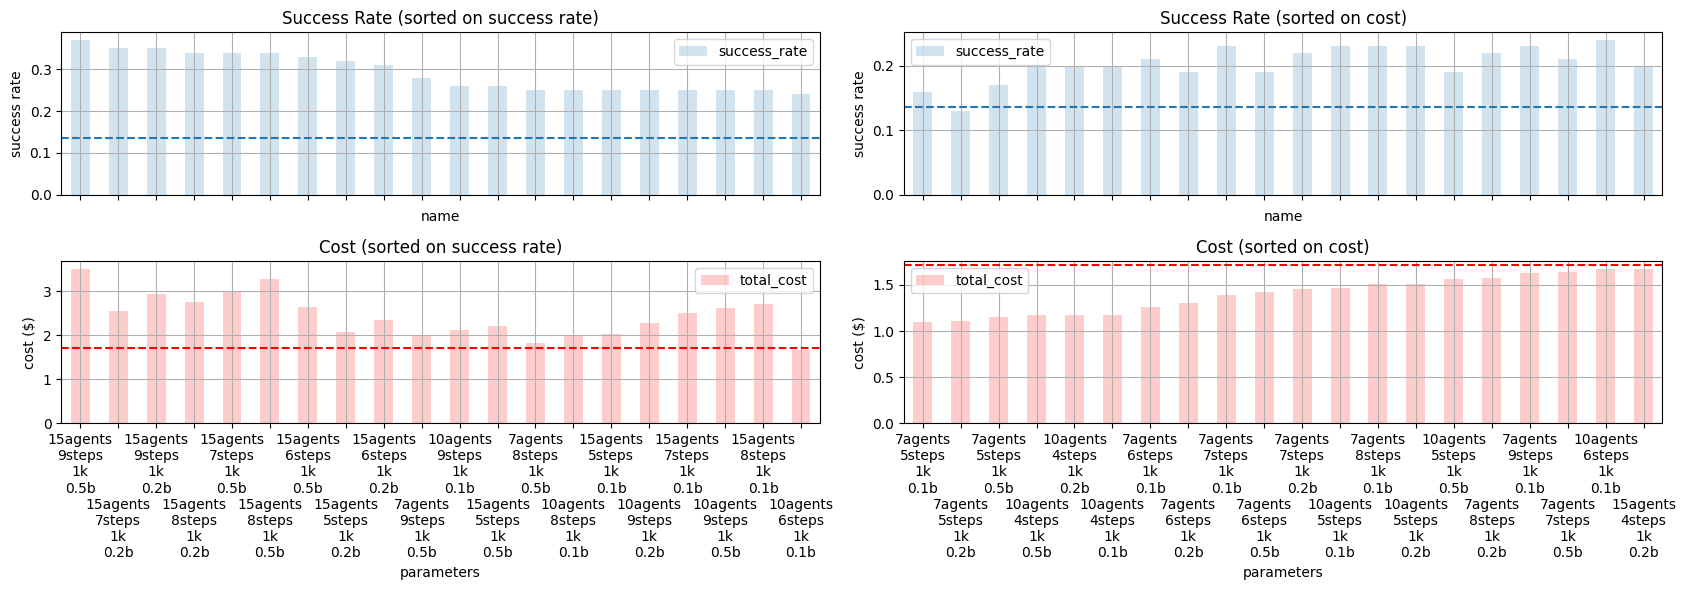

In [9]:
# prioritizing cost

import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axes = plt.subplots(2, 2, figsize=(17, 6))

# Plot sorted with success rate
df_temp = df.copy()
df_temp.sort_values(by=["success_rate", "total_cost"], ascending=[False, True], inplace=True)
df_temp = df_temp.head(20)
plot_sucess_rates(df_temp, axes[0,0], axes[1,0], tot_accuracy, tot_cost, sorted_on="success rate")

# Plot sorted with cost
df_temp = df.copy()
df_temp = df_temp[df_temp.success_rate > 0.12]
df_temp.sort_values(by=["total_cost", "success_rate"], ascending=[True, False], inplace=True)
df_temp = df_temp.head(20)
plot_sucess_rates(df_temp, axes[0,1], axes[1,1], tot_accuracy, tot_cost, sorted_on="cost")

# Adjust layout
plt.tight_layout()
plt.savefig("pics/gameof24/finetuned_gridsearch/best_sr_cost.png", dpi=300)
plt.show()


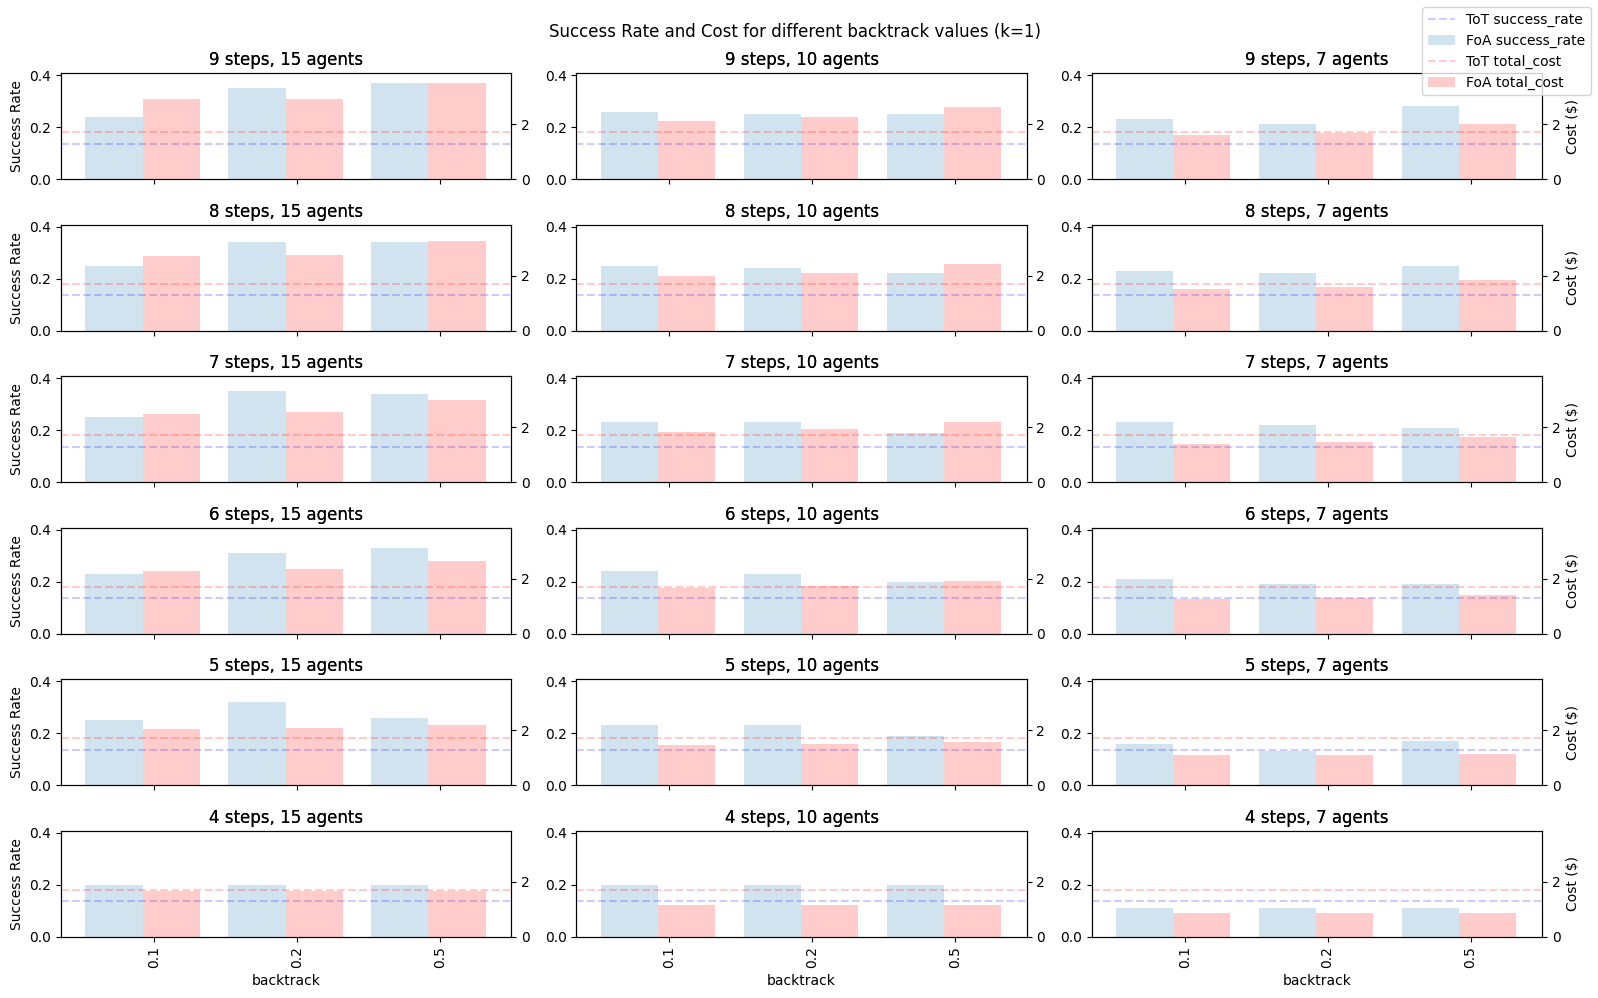

In [10]:
n_steps = sorted(df["n_steps"].unique(), reverse=True)
n_agents = sorted(df["n_agents"].unique(), reverse=True)
ks = sorted(df["k"].unique(), reverse=False)
backtracking = df["backtrack"].unique()
max_accuracy = df["success_rate"].max()
max_cost = df["total_cost"].max()
width = 0.4

for k in ks:
    temp = df[df.k==1].copy()
    temp.sort_values(by=["backtrack"], inplace=True)
    plot_per_agents_and_steps(temp, tot_accuracy, tot_cost, k, save_to=f"pics/gameof24/finetuned_gridsearch/gridsearch_{k}k.png", figsize=(16, 10))

# Stress test

Running the same setup multiple times and averaging cost and success rate.

In [11]:
files = get_files_in_folder("logs_recent/stresstest/gameof24")

results = [get_params(file) for file in files]
results = sorted(results, key=lambda x: x["success_rate"], reverse=True)

df = pd.DataFrame(results)
df["input_tokens"] = df["cost"].apply(lambda x: x["input_tokens"])
df["output_tokens"] = df["cost"].apply(lambda x: x["output_tokens"])
df["total_cost"] = df["cost"].apply(lambda x: x["total_cost"])
df["name"] = df.apply(lambda x: f"{x['n_agents']}agents\n{x['n_steps']}steps\n{x['k']}k\n{x['backtrack']}b", axis=1)

assert (df.groupby(["n_agents", "n_steps", "k", "backtrack"]).count() == 5).any().any()

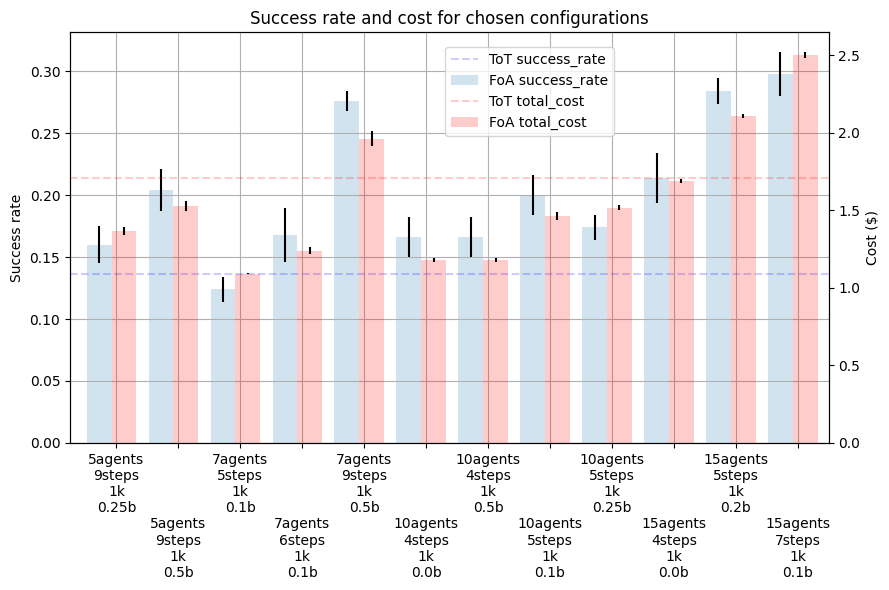

In [12]:
fig, axes = plt.subplots(1,1, figsize=(9, 6))
cost_axis = axes.twinx()

success_rate_data = df.groupby(["n_agents", "n_steps", "k", "backtrack"])["success_rate"].agg(['mean', 'sem'])
total_cost_data = df.groupby(["n_agents", "n_steps", "k", "backtrack"])["total_cost"].agg(['mean', 'sem'])


success_rate_data["mean"].plot(kind="bar", yerr=success_rate_data['sem'], width=-width, position=-width/2, ax=axes, alpha=0.2, label="FoA success_rate")
total_cost_data["mean"].plot(kind="bar",yerr=total_cost_data["sem"], width=width, position=+width/2, ax=cost_axis, color="red", alpha=0.2, label="FoA total_cost")

axes.axhline(y=tot_accuracy, color='b', linestyle='--', alpha=0.2, label="ToT success_rate")  # Adding a horizontal line
cost_axis.axhline(y=tot_cost, color='r', linestyle='--', alpha=0.2, label="ToT total_cost")  # Adding a horizontal line

# No point in plotting CIs for the ToT benchmarks -> ci for success_rate is way too wide
#sr_ci = stats.t.interval(0.95, len(tot_accuracies)-1, loc=np.mean(tot_accuracies), scale=stats.sem(tot_accuracies))
#axes.fill_between(x=range(-1,100) ,y1=sr_ci[0], y2=sr_ci[1], color='blue', alpha=0.1, label = "ToT success rate")
#cost_ci = stats.t.interval(0.95, len(tot_costs)-1, loc=np.mean(tot_costs), scale=stats.sem(tot_costs))
#cost_axis.fill_between(x=range(-1,100) ,y1=cost_ci[0], y2=cost_ci[1], color='red', alpha=0.1, label = "ToT cost")


axes.set_ylabel("Success rate")
cost_axis.set_ylabel("Cost ($)")
axes.set_xlabel(None)

# Combining legends
lines, labels = axes.get_legend_handles_labels()
lines2, labels2 = cost_axis.get_legend_handles_labels()
plt.figlegend(lines + lines2, labels + labels2, loc=(0.5,0.77))

# x-axis tick labels
x_labels  = df.groupby(["n_agents", "n_steps", "k", "backtrack"]).apply(lambda x: x["name"]).drop_duplicates().tolist()
x_labels = [label if i%2==0 else "\n\n\n\n"+label for i, label in enumerate(x_labels)]
axes.set_xticklabels(x_labels, rotation=0) 
axes.grid(True)

# Adjust layout
plt.xlim(-0.75, 11.5)
plt.title("Success rate and cost for chosen configurations")
plt.tight_layout()
plt.savefig("pics/gameof24/stresstest.png", dpi=300)
plt.show()

# Confidence intervals files (Lars)

In [13]:
# FoA
files = get_files_in_folder("logs_recent/stresstest/gameof24")

results = [get_params(file) for file in files]
results = sorted(results, key=lambda x: x["success_rate"], reverse=True)

grouped_experiments = {}

for result in results:
    if result["name"] in grouped_experiments.keys():
        grouped_experiments[result["name"]].append(result["file_path"])
    else:
        grouped_experiments[result["name"]] = [result["file_path"]]

        
for setup, runs in grouped_experiments.items():
    success = {"runs":[], "costs":[]}
    for i, run in enumerate(runs):
        with open(run, 'r') as runfile:
            runresults = json.load(runfile)
        a = runresults

        cost = runresults.pop("Cost")
        success["costs"].append(cost["total_cost"])
        run_success = []
        
        for puzzle, puzzle_results in runresults.items():
            if {"r":1} in puzzle_results["Verifications"]:
                run_success.append(1)
            else:
                run_success.append(0)
        success["runs"].append(run_success)
    with open("results/gameof24/{}.json".format(setup.replace('\n','_')), 'w') as file:
        json.dump(success, file)

In [14]:
#ToT
files = get_files_in_folder("benchmarks/gameof24")

success = {"runs":[], "costs":[]}
for file in files:
    with open(file, 'r') as f:
        run = json.load(f)
    
    run_success = []
    for puzzle in run:
        if {"r":1} in puzzle["infos"]:
            success["runs"].append(1)
        else:
            success["runs"].append(0)
    
    success["runs"].append(run_success)
    success["costs"].append(run[-1]["usage_so_far"]["cost"])

with open("results/gameof24/ToT.json", 'w') as file:
    json.dump(success, file)